# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [2]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

In [3]:
save_dir = 'models/lstm4.67'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [4]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [5]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
model.add(CuDNNLSTM(200))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mae", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               212800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 200)           321600    
_________________________________________________________________
dropout_2 (Dropout)  

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 2s 4ms/step - loss: 0.1332 - val_loss: 0.0816
Epoch 2/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0706 - val_loss: 0.0740
Epoch 3/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0556 - val_loss: 0.0507
Epoch 4/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0529 - val_loss: 0.0544
Epoch 5/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0504 - val_loss: 0.0715
Epoch 6/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0439 - val_loss: 0.0489
Epoch 7/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0393 - val_loss: 0.0406
Epoch 8/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0373 - val_loss: 0.0383
Epoch 9/1000
585/585 [=========

Epoch 77/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0172 - val_loss: 0.0183
Epoch 78/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0173 - val_loss: 0.0187
Epoch 79/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 80/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 81/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 82/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 83/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0165 - val_loss: 0.0152
Epoch 84/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0188
Epoch 85/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 86/1000
585/585 [==============================] - 1s 1ms/step - lo

Epoch 156/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 157/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0141 - val_loss: 0.0164
Epoch 158/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 159/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 160/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0139 - val_loss: 0.0144
Epoch 161/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 162/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0142 - val_loss: 0.0152
Epoch 163/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0138 - val_loss: 0.0165
Epoch 164/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0146 - val_loss: 0.0162
Epoch 165/1000
585/585 [==============================] - 1s 1ms

Epoch 235/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 236/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0135
Epoch 237/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0113
Epoch 238/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 239/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0128 - val_loss: 0.0175
Epoch 240/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 241/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0130
Epoch 242/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0133
Epoch 243/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 244/1000
585/585 [==============================] - 1s 1ms

Epoch 314/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 315/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 316/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 317/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0128
Epoch 318/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 319/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 320/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0113 - val_loss: 0.0124
Epoch 321/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 322/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 323/1000
585/585 [==============================] - 1s 1ms

Epoch 393/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0126
Epoch 394/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0121
Epoch 395/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0106 - val_loss: 0.0114
Epoch 396/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 397/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0106 - val_loss: 0.0119
Epoch 398/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0135
Epoch 399/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 400/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0106 - val_loss: 0.0117
Epoch 401/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 402/1000
585/585 [==============================] - 1s 1ms

Epoch 472/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0104 - val_loss: 0.0122
Epoch 473/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 474/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 475/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0130
Epoch 476/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 477/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 478/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 479/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0109
Epoch 480/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 481/1000
585/585 [==============================] - 1s 1ms

Epoch 551/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 552/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0114
Epoch 553/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 554/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0106 - val_loss: 0.0100
Epoch 555/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 556/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0108
Epoch 557/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 558/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 559/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0117
Epoch 560/1000
585/585 [==============================] - 1s 1ms

Epoch 630/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0125
Epoch 631/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 632/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0145
Epoch 633/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0125
Epoch 634/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 635/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 636/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 637/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 638/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 639/1000
585/585 [==============================] - 1s 1ms

Epoch 709/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0106
Epoch 710/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0103
Epoch 711/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0105
Epoch 712/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 713/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 714/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 715/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0101
Epoch 716/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 717/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0100
Epoch 718/1000
585/585 [==============================] - 1s 1ms

Epoch 788/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0143
Epoch 789/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 790/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0089 - val_loss: 0.0117
Epoch 791/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0131
Epoch 792/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 793/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 794/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0130
Epoch 795/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 796/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0104
Epoch 797/1000
585/585 [==============================] - 1s 1ms

Epoch 867/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0094
Epoch 868/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 869/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 870/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0104
Epoch 871/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0107
Epoch 872/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0110
Epoch 873/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0144
Epoch 874/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 875/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 876/1000
585/585 [==============================] - 1s 1ms

Epoch 946/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 947/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0113
Epoch 948/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 949/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 950/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 951/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0106
Epoch 952/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0111
Epoch 953/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 954/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0107
Epoch 955/1000
585/585 [==============================] - 1s 1ms

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.00013900921518129937
MSE Dev: 0.0003036394922738375
MSE Test: 0.0001632304809639915
MAE Train: 0.007273174483501676
MAE Dev: 0.009397846900606707
MAE Test: 0.00933503482855853


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

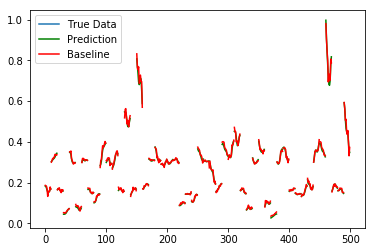

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

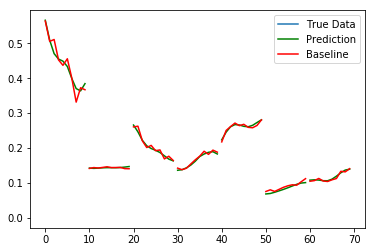

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 8.356416922078855e-05
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 8.356416922078855e-05


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

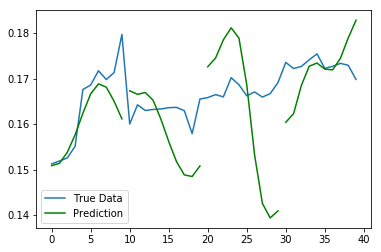

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

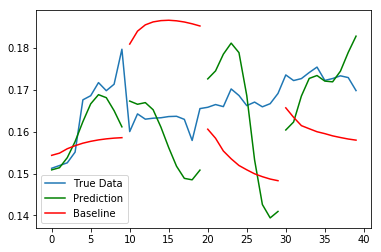

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.007795996838661409
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 0.00011228797376612218


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



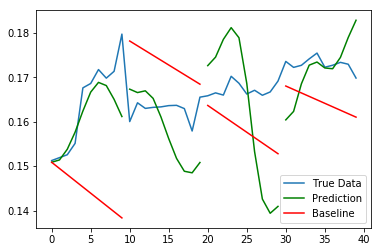

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.007795996838661409
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 0.00011228797376612218


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

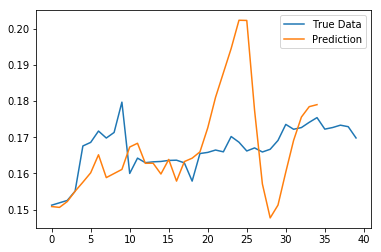

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)

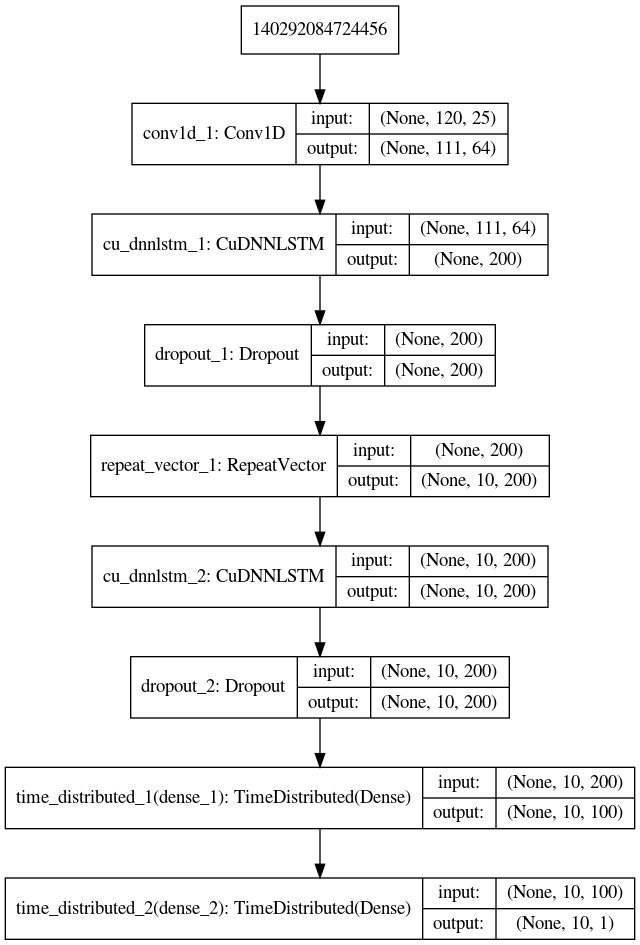

In [7]:
from IPython.display import SVG, Image, display
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_plot.png'))